# **Imports 📢**

In [3]:
!pip install torchmetrics

In [4]:
!pip install prettytable

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Read Dataset

In [6]:
##read dataset


In [7]:
##uncompress


In [8]:
def read_file(file,phase):
    with open(file, 'rb') as fh:
        decompressed_data = fh.read()
    list_data = decompressed_data.decode('utf-8').splitlines()
    with open(phase +".csv","w", newline="") as f:
        writer = csv.writer(f)
        for line in list_data:
            # making cells by using , delimiters
            writer.writerow(line.split(" "))  

In [9]:
read_file('shuttle.trn',"train")

In [10]:
##readfile
test_set = pd.read_csv('shuttledata_test.csv', header=None)

train_set = pd.read_csv('train.csv' , header=None)

train_set.shape , test_set.shape

((43500, 10), (14500, 9))

## Split

In [11]:
train_set , valid_set = train_test_split(train_set , test_size=0.3 , random_state=0)
train_set.shape , valid_set.shape

((30450, 10), (13050, 10))

In [12]:
X_train = train_set.drop(9 , axis=1).values
X_valid = valid_set.drop(9 , axis=1).values
y_train = train_set[9].values
y_train = y_train - 1
y_valid = valid_set[9].values
y_valid = y_valid - 1

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(30450, 9)
(13050, 9)
(30450,)
(13050,)


## Preprocess

In [13]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)

y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [14]:
mu = torch.mean(X_train , dim=0)
std = torch.std(X_train , dim=0)

X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std

## Dataloader

In [15]:
train_dataset = TensorDataset(X_train , y_train)
valid_dataset = TensorDataset(X_valid , y_valid)

train_loader = DataLoader(train_dataset , 1000 , True)
valid_loader = DataLoader(valid_dataset , 2000)

# **Model 🧠**

In [16]:
num_features = 9
num_classes = 7
h1 = 20
h2 = 10

model = nn.Sequential(
                      nn.Linear(num_features , h1),
                      nn.ReLU(),

                      nn.Linear(h1 , h2),
                      nn.ReLU(),
                      
                      nn.Linear(h2 , num_classes)
                      )

model

Sequential(
  (0): Linear(in_features=9, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=7, bias=True)
)

# **Device ⚙️**

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# **Loss ⚖️**

## CrossEntropyLoss

In [18]:
loss_fn = nn.CrossEntropyLoss()

# **Optimizer📻**

## SGD

In [19]:
optimizer = optim.SGD(model.parameters() , lr=0.01 , momentum=0.9 , weight_decay=1e-4)

# **Utils 🧰**

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [21]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass',num_classes=7).to(device)
    
    with tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')
                
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(outputs, targets.int())

            tepoch.set_postfix(loss=loss_train.avg,
                                 accuracy=100.*acc_train.compute().item())
            
    return model, loss_train.avg, acc_train.compute().item()

In [22]:
def evaluate(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass',num_classes=7).to(device)
        
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss_valid.update(loss.item())
            acc_valid(outputs, targets.int())

    return loss_valid.avg, acc_valid.compute()

# **Efficient way for set hyperparams 🔨**

In [23]:
model = nn.Sequential(
                      nn.Linear(num_features , h1),
                      nn.ReLU(),

                      nn.Linear(h1 , h2),
                      nn.ReLU(),
                      
                      nn.Linear(h2 , num_classes)
                      )
model = model.to(device)

optimizer = optim.SGD(model.parameters() , lr=0.01 , momentum=0.9 , weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [24]:
input_batch , output_batch = next(iter(train_loader))
y_pred = model(input_batch)
loss = loss_fn(y_pred , output_batch)
loss

tensor(1.9309, grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [25]:
mini_train_dataset, _ = random_split(train_dataset , (5000 , len(train_dataset)-5000))
mini_loader = DataLoader(mini_train_dataset , 500 , shuffle=True)

In [26]:
num_epochs = 100
for epoch in range(num_epochs):
    model , _ , _ = train_one_epoch(model , mini_loader , loss_fn , optimizer , epoch)

Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 54.79batch/s, accuracy=99.4, loss=0.048]


## Step 3: select best lr

Train all data for one epoch

In [27]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
    model = nn.Sequential(
                          nn.Linear(num_features , h1),
                          nn.ReLU(),

                          nn.Linear(h1 , h2),
                          nn.ReLU(),
                      
                          nn.Linear(h2 , num_classes)
                          )
    model = model.to(device)

    optimizer = optim.SGD(model.parameters() , lr=lr , momentum=0.9 , weight_decay=1e-4)
    
    print(f'LR={lr}')
    for epoch in range(5):
        modl , _ , _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.1


Epoch 4: 100%|██████████| 31/31 [00:01<00:00, 23.11batch/s, accuracy=99.1, loss=0.0596]



LR=0.01


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 32.34batch/s, accuracy=95.2, loss=0.178]



LR=0.001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 31.35batch/s, accuracy=78.4, loss=1.03]



LR=0.0001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 43.30batch/s, accuracy=0.778, loss=2.01]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [28]:
all_params_list = []
for lr in [0.15 , 0.1 , 0.05]:
    for wd in [1e-3 , 1e-4 , 1e-5]:
        
        model = nn.Sequential(
                              nn.Linear(num_features , h1),
                              nn.ReLU(),

                              nn.Linear(h1 , h2),
                              nn.ReLU(),

                              nn.Linear(h2 , num_classes)
                              )
        model = model.to(device)

        optimizer = optim.SGD(model.parameters() , lr=lr , momentum=0.9 , weight_decay=wd)

        print(f'LR={lr}, WD={wd}')
        for epoch in range(5):
             modl , loss_train , _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
                
        loss_train = round(loss_train , ndigits=3)
        params = [lr , wd , loss_train]
        all_params_list.append(params)
        print()

LR=0.15, WD=0.001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 37.95batch/s, accuracy=99.4, loss=0.0471]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 31/31 [00:01<00:00, 25.43batch/s, accuracy=99.5, loss=0.0475]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 50.71batch/s, accuracy=99.3, loss=0.057] 



LR=0.1, WD=0.001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 57.34batch/s, accuracy=99.4, loss=0.0537]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 41.83batch/s, accuracy=99.4, loss=0.0619]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 40.26batch/s, accuracy=99.3, loss=0.0505]



LR=0.05, WD=0.001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 50.01batch/s, accuracy=98.7, loss=0.0859]



LR=0.05, WD=0.0001


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 52.42batch/s, accuracy=98.7, loss=0.0809]



LR=0.05, WD=1e-05


Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 61.90batch/s, accuracy=98.3, loss=0.0878]

In [29]:
from prettytable import PrettyTable

table = PrettyTable(['Learning Rate', 'Weight Decay', 'Loss'])

for rec in all_params_list:
    table.add_row(rec)
    
print(table)

+---------------+--------------+-------+
| Learning Rate | Weight Decay |  Loss |
+---------------+--------------+-------+
|      0.15     |    0.001     | 0.047 |
|      0.15     |    0.0001    | 0.048 |
|      0.15     |    1e-05     | 0.057 |
|      0.1      |    0.001     | 0.054 |
|      0.1      |    0.0001    | 0.062 |
|      0.1      |    1e-05     | 0.051 |
|      0.05     |    0.001     | 0.086 |
|      0.05     |    0.0001    | 0.081 |
|      0.05     |    1e-05     | 0.088 |
+---------------+--------------+-------+


## Step 5: train more epochs

In [30]:
model = nn.Sequential(
                        nn.Linear(num_features , h1),
                        nn.ReLU(),

                        nn.Linear(h1 , h2),
                        nn.ReLU(),

                        nn.Linear(h2 , num_classes)
                              )

model = model.to(device)

optimizer = optim.SGD(model.parameters() , lr=0.15 , momentum=0.9 , weight_decay=1e-5)

In [31]:
num_epoch = 100

In [32]:
best_valid_loss = torch.inf

In [33]:
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

In [34]:
for epoch in range(num_epoch):
    modl , loss_train , acc_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    epoch)
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)
    
    
    loss_valid, acc_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn)
    loss_valid_hist.append(loss_valid)
    acc_valid_hist.append(acc_valid)
    
    if loss_valid < best_valid_loss:
        torch.save(modl, 'model.pt')
        best_valid_loss = loss_valid
    
    print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 31/31 [00:00<00:00, 52.58batch/s, accuracy=79.5, loss=0.661]


Valid: Loss = 0.1713, Acc = 0.9665



Epoch 1: 100%|██████████| 31/31 [00:00<00:00, 49.15batch/s, accuracy=98, loss=0.106]  


Valid: Loss = 0.06696, Acc = 0.9906



Epoch 2: 100%|██████████| 31/31 [00:00<00:00, 43.68batch/s, accuracy=99.3, loss=0.0593]


Valid: Loss = 0.04689, Acc = 0.9915



Epoch 3: 100%|██████████| 31/31 [00:00<00:00, 43.71batch/s, accuracy=99.3, loss=0.0459]


Valid: Loss = 0.03971, Acc = 0.9915



Epoch 4: 100%|██████████| 31/31 [00:00<00:00, 46.19batch/s, accuracy=99.3, loss=0.0387]


Valid: Loss = 0.0343, Acc = 0.9955



Epoch 5: 100%|██████████| 31/31 [00:00<00:00, 47.75batch/s, accuracy=99.5, loss=0.034] 


Valid: Loss = 0.03221, Acc = 0.9954



Epoch 6: 100%|██████████| 31/31 [00:00<00:00, 43.67batch/s, accuracy=99.5, loss=0.0314]


Valid: Loss = 0.03077, Acc = 0.9956



Epoch 7: 100%|██████████| 31/31 [00:00<00:00, 48.12batch/s, accuracy=99.5, loss=0.0293]


Valid: Loss = 0.03003, Acc = 0.9956



Epoch 8: 100%|██████████| 31/31 [00:00<00:00, 55.20batch/s, accuracy=99.5, loss=0.0294]


Valid: Loss = 0.029, Acc = 0.9956



Epoch 9: 100%|██████████| 31/31 [00:00<00:00, 61.31batch/s, accuracy=99.5, loss=0.0271]


Valid: Loss = 0.02815, Acc = 0.9957



Epoch 10: 100%|██████████| 31/31 [00:00<00:00, 62.70batch/s, accuracy=99.6, loss=0.0252]


Valid: Loss = 0.02649, Acc = 0.9959



Epoch 11: 100%|██████████| 31/31 [00:00<00:00, 61.92batch/s, accuracy=99.6, loss=0.0246]


Valid: Loss = 0.02489, Acc = 0.996



Epoch 12: 100%|██████████| 31/31 [00:00<00:00, 53.77batch/s, accuracy=99.6, loss=0.0234]


Valid: Loss = 0.02497, Acc = 0.996



Epoch 13: 100%|██████████| 31/31 [00:00<00:00, 48.34batch/s, accuracy=99.6, loss=0.0222]


Valid: Loss = 0.02473, Acc = 0.9959



Epoch 14: 100%|██████████| 31/31 [00:00<00:00, 40.57batch/s, accuracy=99.6, loss=0.0211]


Valid: Loss = 0.02248, Acc = 0.9959



Epoch 15: 100%|██████████| 31/31 [00:00<00:00, 61.31batch/s, accuracy=99.6, loss=0.0214]


Valid: Loss = 0.02225, Acc = 0.9961



Epoch 16: 100%|██████████| 31/31 [00:00<00:00, 64.76batch/s, accuracy=99.6, loss=0.02]  


Valid: Loss = 0.02154, Acc = 0.996



Epoch 17: 100%|██████████| 31/31 [00:00<00:00, 57.14batch/s, accuracy=99.6, loss=0.0187]


Valid: Loss = 0.01952, Acc = 0.9962



Epoch 18: 100%|██████████| 31/31 [00:00<00:00, 50.95batch/s, accuracy=99.6, loss=0.0185]


Valid: Loss = 0.01952, Acc = 0.9963



Epoch 19: 100%|██████████| 31/31 [00:00<00:00, 54.72batch/s, accuracy=99.6, loss=0.0174]


Valid: Loss = 0.02023, Acc = 0.9963



Epoch 20: 100%|██████████| 31/31 [00:00<00:00, 46.72batch/s, accuracy=99.7, loss=0.0168]


Valid: Loss = 0.01797, Acc = 0.9967



Epoch 21: 100%|██████████| 31/31 [00:00<00:00, 53.38batch/s, accuracy=99.7, loss=0.0174]


Valid: Loss = 0.01705, Acc = 0.9968



Epoch 22: 100%|██████████| 31/31 [00:00<00:00, 35.50batch/s, accuracy=99.7, loss=0.0166]


Valid: Loss = 0.01755, Acc = 0.9967



Epoch 23: 100%|██████████| 31/31 [00:01<00:00, 27.70batch/s, accuracy=99.7, loss=0.0149]


Valid: Loss = 0.01632, Acc = 0.9969



Epoch 24: 100%|██████████| 31/31 [00:00<00:00, 34.16batch/s, accuracy=99.7, loss=0.0144]


Valid: Loss = 0.01615, Acc = 0.9969



Epoch 25: 100%|██████████| 31/31 [00:00<00:00, 34.54batch/s, accuracy=99.7, loss=0.0133]


Valid: Loss = 0.01473, Acc = 0.9972



Epoch 26: 100%|██████████| 31/31 [00:01<00:00, 28.06batch/s, accuracy=99.7, loss=0.0134]


Valid: Loss = 0.01437, Acc = 0.9972



Epoch 27: 100%|██████████| 31/31 [00:00<00:00, 34.97batch/s, accuracy=99.7, loss=0.0142]


Valid: Loss = 0.01513, Acc = 0.9969



Epoch 28: 100%|██████████| 31/31 [00:00<00:00, 35.72batch/s, accuracy=99.7, loss=0.0129] 


Valid: Loss = 0.01466, Acc = 0.9972



Epoch 29: 100%|██████████| 31/31 [00:00<00:00, 42.66batch/s, accuracy=99.7, loss=0.0116] 


Valid: Loss = 0.01338, Acc = 0.9971



Epoch 30: 100%|██████████| 31/31 [00:00<00:00, 42.93batch/s, accuracy=99.7, loss=0.0124]


Valid: Loss = 0.01246, Acc = 0.9972



Epoch 31: 100%|██████████| 31/31 [00:00<00:00, 57.08batch/s, accuracy=99.7, loss=0.0115] 


Valid: Loss = 0.01322, Acc = 0.9972



Epoch 32: 100%|██████████| 31/31 [00:00<00:00, 47.76batch/s, accuracy=99.7, loss=0.0111]


Valid: Loss = 0.01262, Acc = 0.9972



Epoch 33: 100%|██████████| 31/31 [00:00<00:00, 53.50batch/s, accuracy=99.7, loss=0.0112]


Valid: Loss = 0.01096, Acc = 0.9973



Epoch 34: 100%|██████████| 31/31 [00:00<00:00, 58.65batch/s, accuracy=99.7, loss=0.00964]


Valid: Loss = 0.01192, Acc = 0.9975



Epoch 35: 100%|██████████| 31/31 [00:00<00:00, 62.94batch/s, accuracy=99.8, loss=0.0105]


Valid: Loss = 0.01185, Acc = 0.9972



Epoch 36: 100%|██████████| 31/31 [00:00<00:00, 64.74batch/s, accuracy=99.7, loss=0.00979]


Valid: Loss = 0.01416, Acc = 0.9972



Epoch 37: 100%|██████████| 31/31 [00:00<00:00, 57.45batch/s, accuracy=99.7, loss=0.00971]


Valid: Loss = 0.01235, Acc = 0.9974



Epoch 38: 100%|██████████| 31/31 [00:00<00:00, 41.10batch/s, accuracy=99.7, loss=0.00913]


Valid: Loss = 0.01325, Acc = 0.9974



Epoch 39: 100%|██████████| 31/31 [00:00<00:00, 51.21batch/s, accuracy=99.7, loss=0.0101] 


Valid: Loss = 0.01354, Acc = 0.9977



Epoch 40: 100%|██████████| 31/31 [00:00<00:00, 47.53batch/s, accuracy=99.8, loss=0.00869]


Valid: Loss = 0.01224, Acc = 0.9976



Epoch 41: 100%|██████████| 31/31 [00:00<00:00, 44.07batch/s, accuracy=99.7, loss=0.00845]


Valid: Loss = 0.01093, Acc = 0.9975



Epoch 42: 100%|██████████| 31/31 [00:00<00:00, 42.72batch/s, accuracy=99.8, loss=0.00849]


Valid: Loss = 0.01103, Acc = 0.9975



Epoch 43: 100%|██████████| 31/31 [00:00<00:00, 50.91batch/s, accuracy=99.8, loss=0.00984]


Valid: Loss = 0.01354, Acc = 0.997



Epoch 44: 100%|██████████| 31/31 [00:00<00:00, 52.49batch/s, accuracy=99.8, loss=0.0102]


Valid: Loss = 0.0119, Acc = 0.9977



Epoch 45: 100%|██████████| 31/31 [00:00<00:00, 65.15batch/s, accuracy=99.8, loss=0.00916]


Valid: Loss = 0.01008, Acc = 0.9975



Epoch 46: 100%|██████████| 31/31 [00:00<00:00, 63.83batch/s, accuracy=99.8, loss=0.00776]


Valid: Loss = 0.01165, Acc = 0.9973



Epoch 47: 100%|██████████| 31/31 [00:00<00:00, 51.98batch/s, accuracy=99.8, loss=0.00904]


Valid: Loss = 0.01143, Acc = 0.998



Epoch 48: 100%|██████████| 31/31 [00:00<00:00, 57.80batch/s, accuracy=99.8, loss=0.00824]


Valid: Loss = 0.009896, Acc = 0.998



Epoch 49: 100%|██████████| 31/31 [00:00<00:00, 68.06batch/s, accuracy=99.8, loss=0.00802]


Valid: Loss = 0.009465, Acc = 0.998



Epoch 50: 100%|██████████| 31/31 [00:00<00:00, 64.80batch/s, accuracy=99.8, loss=0.00715]


Valid: Loss = 0.0107, Acc = 0.998



Epoch 51: 100%|██████████| 31/31 [00:00<00:00, 64.75batch/s, accuracy=99.8, loss=0.00722]


Valid: Loss = 0.009298, Acc = 0.9979



Epoch 52: 100%|██████████| 31/31 [00:00<00:00, 58.20batch/s, accuracy=99.8, loss=0.00722]


Valid: Loss = 0.009683, Acc = 0.9979



Epoch 53: 100%|██████████| 31/31 [00:00<00:00, 58.72batch/s, accuracy=99.8, loss=0.00767]


Valid: Loss = 0.01085, Acc = 0.998



Epoch 54: 100%|██████████| 31/31 [00:00<00:00, 65.02batch/s, accuracy=99.8, loss=0.00716]


Valid: Loss = 0.01012, Acc = 0.9977



Epoch 55: 100%|██████████| 31/31 [00:00<00:00, 65.44batch/s, accuracy=99.8, loss=0.00661]


Valid: Loss = 0.009944, Acc = 0.9985



Epoch 56: 100%|██████████| 31/31 [00:00<00:00, 61.24batch/s, accuracy=99.8, loss=0.00574]


Valid: Loss = 0.009959, Acc = 0.9983



Epoch 57: 100%|██████████| 31/31 [00:00<00:00, 56.49batch/s, accuracy=99.8, loss=0.00836]


Valid: Loss = 0.01033, Acc = 0.9983



Epoch 58: 100%|██████████| 31/31 [00:00<00:00, 56.82batch/s, accuracy=99.8, loss=0.00619]


Valid: Loss = 0.009306, Acc = 0.9981



Epoch 59: 100%|██████████| 31/31 [00:00<00:00, 64.47batch/s, accuracy=99.8, loss=0.00553]


Valid: Loss = 0.009219, Acc = 0.9984



Epoch 60: 100%|██████████| 31/31 [00:00<00:00, 47.14batch/s, accuracy=99.8, loss=0.00565]


Valid: Loss = 0.008786, Acc = 0.9983



Epoch 61: 100%|██████████| 31/31 [00:00<00:00, 51.38batch/s, accuracy=99.8, loss=0.00544]


Valid: Loss = 0.009263, Acc = 0.9985



Epoch 62: 100%|██████████| 31/31 [00:00<00:00, 41.30batch/s, accuracy=99.9, loss=0.00497]


Valid: Loss = 0.009043, Acc = 0.9985



Epoch 63: 100%|██████████| 31/31 [00:00<00:00, 46.96batch/s, accuracy=99.9, loss=0.0054] 


Valid: Loss = 0.009382, Acc = 0.9984



Epoch 64: 100%|██████████| 31/31 [00:00<00:00, 55.41batch/s, accuracy=99.8, loss=0.00525]


Valid: Loss = 0.01855, Acc = 0.9982



Epoch 65: 100%|██████████| 31/31 [00:00<00:00, 61.55batch/s, accuracy=99.8, loss=0.00729]


Valid: Loss = 0.01703, Acc = 0.998



Epoch 66: 100%|██████████| 31/31 [00:00<00:00, 68.46batch/s, accuracy=99.8, loss=0.00696]


Valid: Loss = 0.0162, Acc = 0.9984



Epoch 67: 100%|██████████| 31/31 [00:00<00:00, 60.70batch/s, accuracy=99.9, loss=0.00541]


Valid: Loss = 0.01623, Acc = 0.9985



Epoch 68: 100%|██████████| 31/31 [00:00<00:00, 59.38batch/s, accuracy=99.9, loss=0.0057] 


Valid: Loss = 0.01625, Acc = 0.9983



Epoch 69: 100%|██████████| 31/31 [00:00<00:00, 64.05batch/s, accuracy=99.8, loss=0.00688]


Valid: Loss = 0.01653, Acc = 0.9985



Epoch 70: 100%|██████████| 31/31 [00:00<00:00, 62.99batch/s, accuracy=99.8, loss=0.00608]


Valid: Loss = 0.01522, Acc = 0.9983



Epoch 71: 100%|██████████| 31/31 [00:00<00:00, 67.58batch/s, accuracy=99.9, loss=0.00568]


Valid: Loss = 0.01508, Acc = 0.9982



Epoch 72: 100%|██████████| 31/31 [00:00<00:00, 54.15batch/s, accuracy=99.9, loss=0.0049] 


Valid: Loss = 0.01503, Acc = 0.9988



Epoch 73: 100%|██████████| 31/31 [00:00<00:00, 60.46batch/s, accuracy=99.9, loss=0.00503]


Valid: Loss = 0.01346, Acc = 0.9988



Epoch 74: 100%|██████████| 31/31 [00:00<00:00, 68.04batch/s, accuracy=99.9, loss=0.00523]


Valid: Loss = 0.0131, Acc = 0.9987



Epoch 75: 100%|██████████| 31/31 [00:00<00:00, 65.89batch/s, accuracy=99.9, loss=0.00432]


Valid: Loss = 0.01263, Acc = 0.9987



Epoch 76: 100%|██████████| 31/31 [00:00<00:00, 65.58batch/s, accuracy=99.9, loss=0.00454]


Valid: Loss = 0.01263, Acc = 0.9989



Epoch 77: 100%|██████████| 31/31 [00:00<00:00, 59.01batch/s, accuracy=99.9, loss=0.00413]


Valid: Loss = 0.01116, Acc = 0.9989



Epoch 78: 100%|██████████| 31/31 [00:00<00:00, 58.74batch/s, accuracy=99.9, loss=0.00428]


Valid: Loss = 0.01219, Acc = 0.9985



Epoch 79: 100%|██████████| 31/31 [00:00<00:00, 67.86batch/s, accuracy=99.9, loss=0.00389]


Valid: Loss = 0.01107, Acc = 0.9989



Epoch 80: 100%|██████████| 31/31 [00:00<00:00, 63.87batch/s, accuracy=99.9, loss=0.00369]


Valid: Loss = 0.0111, Acc = 0.9989



Epoch 81: 100%|██████████| 31/31 [00:00<00:00, 67.72batch/s, accuracy=99.9, loss=0.00403]


Valid: Loss = 0.01129, Acc = 0.9986



Epoch 82: 100%|██████████| 31/31 [00:00<00:00, 47.21batch/s, accuracy=99.9, loss=0.00444]


Valid: Loss = 0.0106, Acc = 0.9991



Epoch 83: 100%|██████████| 31/31 [00:00<00:00, 50.38batch/s, accuracy=99.9, loss=0.0036] 


Valid: Loss = 0.01003, Acc = 0.9989



Epoch 84: 100%|██████████| 31/31 [00:00<00:00, 48.02batch/s, accuracy=99.9, loss=0.00432]


Valid: Loss = 0.009432, Acc = 0.999



Epoch 85: 100%|██████████| 31/31 [00:00<00:00, 46.62batch/s, accuracy=99.9, loss=0.004]  


Valid: Loss = 0.009324, Acc = 0.999



Epoch 86: 100%|██████████| 31/31 [00:00<00:00, 48.89batch/s, accuracy=99.9, loss=0.00411]


Valid: Loss = 0.01028, Acc = 0.9989



Epoch 87: 100%|██████████| 31/31 [00:00<00:00, 43.88batch/s, accuracy=99.9, loss=0.00593]


Valid: Loss = 0.009605, Acc = 0.9989



Epoch 88: 100%|██████████| 31/31 [00:01<00:00, 28.79batch/s, accuracy=99.9, loss=0.0052] 


Valid: Loss = 0.008275, Acc = 0.9989



Epoch 89: 100%|██████████| 31/31 [00:00<00:00, 34.44batch/s, accuracy=99.9, loss=0.00438]


Valid: Loss = 0.008305, Acc = 0.9989



Epoch 90: 100%|██████████| 31/31 [00:00<00:00, 62.55batch/s, accuracy=99.9, loss=0.00488]


Valid: Loss = 0.01221, Acc = 0.9992



Epoch 91: 100%|██████████| 31/31 [00:00<00:00, 60.27batch/s, accuracy=99.9, loss=0.00378]


Valid: Loss = 0.01111, Acc = 0.9989



Epoch 92: 100%|██████████| 31/31 [00:00<00:00, 50.12batch/s, accuracy=99.9, loss=0.00341]


Valid: Loss = 0.01057, Acc = 0.9989



Epoch 93: 100%|██████████| 31/31 [00:00<00:00, 59.66batch/s, accuracy=99.9, loss=0.00345]


Valid: Loss = 0.01039, Acc = 0.9988



Epoch 94: 100%|██████████| 31/31 [00:00<00:00, 66.30batch/s, accuracy=99.9, loss=0.00399]


Valid: Loss = 0.01094, Acc = 0.9989



Epoch 95: 100%|██████████| 31/31 [00:00<00:00, 65.56batch/s, accuracy=99.9, loss=0.00468]


Valid: Loss = 0.01282, Acc = 0.9989



Epoch 96: 100%|██████████| 31/31 [00:00<00:00, 39.55batch/s, accuracy=99.9, loss=0.00588]


Valid: Loss = 0.01062, Acc = 0.9989



Epoch 97: 100%|██████████| 31/31 [00:00<00:00, 40.68batch/s, accuracy=99.9, loss=0.00379]


Valid: Loss = 0.008892, Acc = 0.999



Epoch 98: 100%|██████████| 31/31 [00:00<00:00, 49.03batch/s, accuracy=99.9, loss=0.0038] 


Valid: Loss = 0.009465, Acc = 0.9989



Epoch 99: 100%|██████████| 31/31 [00:00<00:00, 55.11batch/s, accuracy=99.9, loss=0.00308]


Valid: Loss = 0.008654, Acc = 0.9991



# **Plot📉**

### Loss

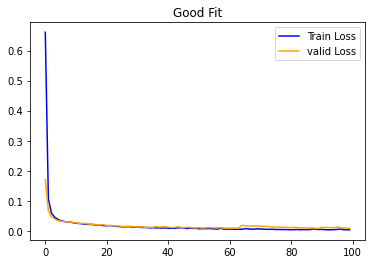

In [35]:
plt.plot(loss_train_hist , color='b' , label='Train Loss');
plt.plot(loss_valid_hist , color='orange' , label='valid Loss');
plt.title('Good Fit')
plt.legend();

### Accuracy

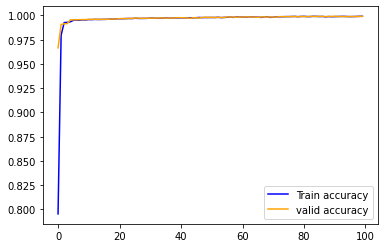

In [36]:
plt.plot(acc_train_hist , color='b' , label='Train accuracy');
plt.plot(acc_valid_hist , color='orange' , label='valid accuracy');
plt.legend();

# **Save & Prediction🔎**

In [37]:
## (Save model.pt) --> Done

In [38]:
test_set = test_set.values

In [39]:
test_set = torch.FloatTensor(test_set)

In [40]:
test_set = (test_set - mu) / std

In [41]:
test_set = test_set.to(device)

In [42]:
pred = model(test_set)
pred = torch.argmax(pred , dim=1)
pred.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

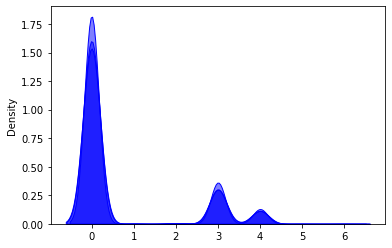

In [43]:
sns.kdeplot(pred , alpha=0.5 , color='b' , fill=True);
sns.kdeplot(y_valid , alpha=0.5 , color='b', fill=True);
sns.kdeplot(y_train , alpha=0.5 , color='b', fill=True);

In [44]:
prediction = pred.cpu().detach().numpy()

df_pred = pd.DataFrame(prediction , columns=['Pred'])
df_pred.to_csv("Prediction",index=False)

# **Bonus🌟**

In [92]:
num_features = 9
num_classes = 7
h1 = 200
h2 = 100
h3 = 40
h4 = 12

In [93]:
model = nn.Sequential(
                        nn.Linear(num_features , h1),
                        nn.ReLU(),

                        nn.Linear(h1 , h2),
                        nn.ReLU(),

                        nn.Linear(h2 , h3),
                        nn.ReLU(),
                        
                        nn.Linear(h3 , h4),
                        nn.ReLU(),
                        
                        nn.Linear(h4 , num_classes)
                              )

model = model.to(device)

optimizer = optim.SGD(model.parameters() , lr=0.3 , momentum=0.9)

In [94]:
num_epoch = 50

In [95]:
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

In [96]:
for epoch in range(num_epoch):
    modl , loss_train , acc_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    epoch)
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)
    
    
    loss_valid, acc_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn)
    loss_valid_hist.append(loss_valid)
    acc_valid_hist.append(acc_valid)
    
    print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 31/31 [00:02<00:00, 13.06batch/s, accuracy=78.6, loss=0.654]


Valid: Loss = 0.1646, Acc = 0.9382



Epoch 1: 100%|██████████| 31/31 [00:02<00:00, 12.62batch/s, accuracy=97.5, loss=0.104]


Valid: Loss = 0.06649, Acc = 0.9811



Epoch 2: 100%|██████████| 31/31 [00:02<00:00, 12.55batch/s, accuracy=99.3, loss=0.0451]


Valid: Loss = 0.03513, Acc = 0.9941



Epoch 3: 100%|██████████| 31/31 [00:02<00:00, 11.45batch/s, accuracy=99.2, loss=0.0411]


Valid: Loss = 0.05672, Acc = 0.9868



Epoch 4: 100%|██████████| 31/31 [00:02<00:00, 13.27batch/s, accuracy=99.4, loss=0.0343]


Valid: Loss = 0.02849, Acc = 0.9959



Epoch 5: 100%|██████████| 31/31 [00:02<00:00, 13.21batch/s, accuracy=99.5, loss=0.0284]


Valid: Loss = 0.02706, Acc = 0.9956



Epoch 6: 100%|██████████| 31/31 [00:02<00:00, 13.00batch/s, accuracy=99.5, loss=0.0261]


Valid: Loss = 0.02547, Acc = 0.9956



Epoch 7: 100%|██████████| 31/31 [00:02<00:00, 13.33batch/s, accuracy=99.5, loss=0.0248]


Valid: Loss = 0.02392, Acc = 0.9957



Epoch 8: 100%|██████████| 31/31 [00:02<00:00, 11.79batch/s, accuracy=99.5, loss=0.0225]


Valid: Loss = 0.02363, Acc = 0.9957



Epoch 9: 100%|██████████| 31/31 [00:02<00:00, 12.70batch/s, accuracy=99.6, loss=0.0202]


Valid: Loss = 0.02196, Acc = 0.9963



Epoch 10: 100%|██████████| 31/31 [00:02<00:00, 13.21batch/s, accuracy=99.6, loss=0.0203]


Valid: Loss = 0.02041, Acc = 0.9964



Epoch 11: 100%|██████████| 31/31 [00:02<00:00, 12.74batch/s, accuracy=99.6, loss=0.0179]


Valid: Loss = 0.01833, Acc = 0.9964



Epoch 12: 100%|██████████| 31/31 [00:02<00:00, 12.86batch/s, accuracy=99.6, loss=0.0163]


Valid: Loss = 0.02173, Acc = 0.9963



Epoch 13: 100%|██████████| 31/31 [00:02<00:00, 12.07batch/s, accuracy=99.6, loss=0.0156]


Valid: Loss = 0.01669, Acc = 0.9968



Epoch 14: 100%|██████████| 31/31 [00:02<00:00, 12.20batch/s, accuracy=99.7, loss=0.0126]


Valid: Loss = 0.01464, Acc = 0.9971



Epoch 15: 100%|██████████| 31/31 [00:02<00:00, 13.41batch/s, accuracy=99.7, loss=0.0136]


Valid: Loss = 0.01363, Acc = 0.9969



Epoch 16: 100%|██████████| 31/31 [00:02<00:00, 13.38batch/s, accuracy=99.7, loss=0.0148]


Valid: Loss = 0.01878, Acc = 0.9966



Epoch 17: 100%|██████████| 31/31 [00:02<00:00, 12.88batch/s, accuracy=99.7, loss=0.0136]


Valid: Loss = 0.01877, Acc = 0.9968



Epoch 18: 100%|██████████| 31/31 [00:02<00:00, 12.83batch/s, accuracy=99.7, loss=0.0119]


Valid: Loss = 0.01837, Acc = 0.997



Epoch 19: 100%|██████████| 31/31 [00:02<00:00, 12.13batch/s, accuracy=99.7, loss=0.0102] 


Valid: Loss = 0.01453, Acc = 0.9976



Epoch 20: 100%|██████████| 31/31 [00:02<00:00, 12.91batch/s, accuracy=99.8, loss=0.00896]


Valid: Loss = 0.01333, Acc = 0.9976



Epoch 21: 100%|██████████| 31/31 [00:02<00:00, 13.24batch/s, accuracy=99.8, loss=0.00842]


Valid: Loss = 0.01462, Acc = 0.9972



Epoch 22: 100%|██████████| 31/31 [00:02<00:00, 13.27batch/s, accuracy=99.8, loss=0.00791]


Valid: Loss = 0.011, Acc = 0.9979



Epoch 23: 100%|██████████| 31/31 [00:02<00:00, 12.86batch/s, accuracy=99.8, loss=0.00715]


Valid: Loss = 0.009315, Acc = 0.9979



Epoch 24: 100%|██████████| 31/31 [00:02<00:00, 11.69batch/s, accuracy=99.8, loss=0.00851]


Valid: Loss = 0.009411, Acc = 0.9979



Epoch 25: 100%|██████████| 31/31 [00:02<00:00, 13.25batch/s, accuracy=99.8, loss=0.00715]


Valid: Loss = 0.01035, Acc = 0.9973



Epoch 26: 100%|██████████| 31/31 [00:02<00:00, 13.62batch/s, accuracy=99.8, loss=0.00674]


Valid: Loss = 0.02167, Acc = 0.998



Epoch 27: 100%|██████████| 31/31 [00:02<00:00, 13.42batch/s, accuracy=99.8, loss=0.00621]


Valid: Loss = 0.02036, Acc = 0.998



Epoch 28: 100%|██████████| 31/31 [00:02<00:00, 13.15batch/s, accuracy=99.8, loss=0.00627]


Valid: Loss = 0.02102, Acc = 0.998



Epoch 29: 100%|██████████| 31/31 [00:02<00:00, 12.76batch/s, accuracy=99.8, loss=0.00495]


Valid: Loss = 0.01581, Acc = 0.998



Epoch 30: 100%|██████████| 31/31 [00:02<00:00, 12.39batch/s, accuracy=99.8, loss=0.0117]


Valid: Loss = 0.01119, Acc = 0.9982



Epoch 31: 100%|██████████| 31/31 [00:02<00:00, 13.08batch/s, accuracy=99.8, loss=0.00686]


Valid: Loss = 0.01144, Acc = 0.9982



Epoch 32: 100%|██████████| 31/31 [00:02<00:00, 13.73batch/s, accuracy=99.8, loss=0.0137] 


Valid: Loss = 0.02771, Acc = 0.9971



Epoch 33: 100%|██████████| 31/31 [00:02<00:00, 13.67batch/s, accuracy=99.8, loss=0.00982]


Valid: Loss = 0.01453, Acc = 0.9979



Epoch 34: 100%|██████████| 31/31 [00:02<00:00, 13.52batch/s, accuracy=99.8, loss=0.00662]


Valid: Loss = 0.01134, Acc = 0.9982



Epoch 35: 100%|██████████| 31/31 [00:02<00:00, 11.91batch/s, accuracy=99.8, loss=0.0059] 


Valid: Loss = 0.007489, Acc = 0.9985



Epoch 36: 100%|██████████| 31/31 [00:02<00:00, 13.27batch/s, accuracy=99.9, loss=0.00504]


Valid: Loss = 0.00635, Acc = 0.9985



Epoch 37: 100%|██████████| 31/31 [00:02<00:00, 13.62batch/s, accuracy=99.9, loss=0.00376]


Valid: Loss = 0.005735, Acc = 0.9986



Epoch 38: 100%|██████████| 31/31 [00:02<00:00, 13.59batch/s, accuracy=99.9, loss=0.00361]


Valid: Loss = 0.006947, Acc = 0.9986



Epoch 39: 100%|██████████| 31/31 [00:02<00:00, 13.10batch/s, accuracy=99.9, loss=0.00727]


Valid: Loss = 0.0214, Acc = 0.9975



Epoch 40: 100%|██████████| 31/31 [00:02<00:00, 12.44batch/s, accuracy=99.8, loss=0.0072] 


Valid: Loss = 0.01236, Acc = 0.9985



Epoch 41: 100%|██████████| 31/31 [00:02<00:00, 12.60batch/s, accuracy=99.9, loss=0.0046] 


Valid: Loss = 0.009576, Acc = 0.9987



Epoch 42: 100%|██████████| 31/31 [00:02<00:00, 13.13batch/s, accuracy=99.9, loss=0.0032] 


Valid: Loss = 0.008137, Acc = 0.9991



Epoch 43: 100%|██████████| 31/31 [00:02<00:00, 13.52batch/s, accuracy=99.9, loss=0.00255]


Valid: Loss = 0.007225, Acc = 0.9989



Epoch 44: 100%|██████████| 31/31 [00:02<00:00, 13.54batch/s, accuracy=99.9, loss=0.00231]


Valid: Loss = 0.007808, Acc = 0.9988



Epoch 45: 100%|██████████| 31/31 [00:02<00:00, 12.89batch/s, accuracy=99.9, loss=0.00264]


Valid: Loss = 0.007378, Acc = 0.9991



Epoch 46: 100%|██████████| 31/31 [00:02<00:00, 11.41batch/s, accuracy=99.9, loss=0.00251]


Valid: Loss = 0.00562, Acc = 0.9989



Epoch 47: 100%|██████████| 31/31 [00:02<00:00, 11.93batch/s, accuracy=99.9, loss=0.00242]


Valid: Loss = 0.004737, Acc = 0.9989



Epoch 48: 100%|██████████| 31/31 [00:02<00:00, 13.04batch/s, accuracy=99.9, loss=0.00211]


Valid: Loss = 0.00469, Acc = 0.9991



Epoch 49: 100%|██████████| 31/31 [00:02<00:00, 13.12batch/s, accuracy=99.9, loss=0.0021] 


Valid: Loss = 0.004488, Acc = 0.9992



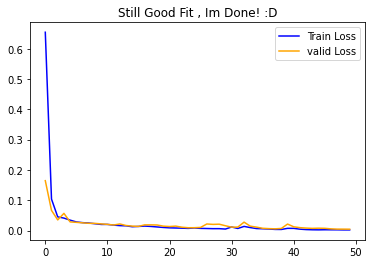

In [99]:
plt.plot(loss_train_hist , color='b' , label='Train Loss');
plt.plot(loss_valid_hist , color='orange' , label='valid Loss');
plt.title('Still Good Fit , Im Done! :D')
plt.legend();